# 8. PyTorch Basics - Good practices in Deep Learning Projects

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.3 (09/02/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10.0)
- Numpy (tested on v2.2.1)
- Torch (tested on v2.7.0+cu124)
- Torchvision (tested on v0.22.0+cu124)

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### The MNIST Dataset

As in the previous notebook

In [3]:
# Define transform to convert images to tensors and normalize them
transform_data = Compose([ToTensor(),
                          Normalize((0.1307,), (0.3081,))])

# Load the data
batch_size = 256
train_dataset = MNIST(root='./mnist/', train = True, download = True, transform = transform_data)
test_dataset = MNIST(root='./mnist/', train = False, download = True, transform = transform_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

### Our deep neural network

As in the previous notebook.

However, we have stremalined the DeepNeuralNet class and its init method so that it can work with any number of elements in the list n_h (instead of just 3). The Sequential will then adjust automatically to produce any appropriate number of DenseReLU layers and finish with a single DenseSoftmax one. 

In [4]:
class DenseReLU(torch.nn.Module):
    def __init__(self, n_x, n_y):
        super().__init__()
        # Define Linear layer using the nn.Linear()
        self.fc = torch.nn.Linear(n_x, n_y)
    
    def forward(self, x):
        # Wx + b operation
        # Using ReLU operation as activation after
        return torch.relu(self.fc(x))

In [5]:
class DenseNoReLU(torch.nn.Module):
    def __init__(self, n_x, n_y):
        super().__init__()
        # Define Linear layer using the nn.Linear()
        self.fc = torch.nn.Linear(n_x, n_y)
    
    def forward(self, x):
        # Wx + b operation
        return self.fc(x)

In [6]:
class DeepNeuralNet(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y):
        super().__init__()
        # Define the correct number of Dense + ReLU layers based on n_h,
        # followed by one final Dense + Softmax layer
        values = [n_x] + n_h
        self.processing_layers = [DenseReLU(values[i], values[i + 1]) for i in range(len(values) - 1)]
        self.processing_layers += [DenseNoReLU(n_h[-1], n_y)]
        
        # Combine all layers
        # Important: note the * symbol before the list of layers in self.processing_layers
        # Not sure what it does? Check the *args and **kwargs concepts in Python.
        self.combined_layers = torch.nn.Sequential(*self.processing_layers)

    
    def forward(self, x):
        # Flatten images (transform them from 28x28 2D matrices to 784 1D vectors)
        x = x.view(x.size(0), -1)
        # Pass through all four layers
        out = self.combined_layers(x)
        return out

Let us try our Deep Neural Net class with more layers, e.g. n_h $ = [320, 160, 80, 40, 20] $.

In [7]:
# Initialize the model
model = DeepNeuralNet(n_x = 784, n_h = [320, 160, 80, 40, 20], n_y = 10).to(device)
# Set model in train mode!
model.train()
# This will display a recap of the different layers
print(model.modules)

<bound method Module.modules of DeepNeuralNet(
  (combined_layers): Sequential(
    (0): DenseReLU(
      (fc): Linear(in_features=784, out_features=320, bias=True)
    )
    (1): DenseReLU(
      (fc): Linear(in_features=320, out_features=160, bias=True)
    )
    (2): DenseReLU(
      (fc): Linear(in_features=160, out_features=80, bias=True)
    )
    (3): DenseReLU(
      (fc): Linear(in_features=80, out_features=40, bias=True)
    )
    (4): DenseReLU(
      (fc): Linear(in_features=40, out_features=20, bias=True)
    )
    (5): DenseNoReLU(
      (fc): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)>


### Number of layers/neurons vs overfitting tradeoff

In the previous noteboo, we raised a fairly important question: **what is the appropriate number of layers to use and how many neurons should we use on each layer?**

We established that there is no fixed rule for how many layers should be used in a deep neural network. Instead, the number of layers, as well as the number of neurons in each layer, should be chosen based on the complexity of the task and the amount of available data.

In general, deep neural networks with many layers (hundreds or even thousands) can learn very complex patterns in data, but they also require a large amount of data and computational resources to train. If the network is too deep, it may also be prone to overfitting, which can hinder its generalization performance on unseen data.

On the other hand, shallow networks with fewer layers may be easier to train and require less data, but they may not be able to learn as complex patterns and may not achieve as high performance on some tasks.

Finding the optimal number of layers and the optimal architecture of a deep neural network is often a trade-off between model complexity, computational resources, and performance, and requires some experimentation and model selection.

### Before we continue, reworking the trainer() function to get performance curves

We just add two lists keeping track of the train and test accuracies during training. Values will be appended to them during training. The entire code is then brought into a trainer() function for convenience.

In [8]:
def trainer(model, train_loader, test_loader):
    
    # History for train acc, test acc
    train_accs = []
    test_accs = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

    # Training model
    num_epochs = 10
    for epoch in range(num_epochs):

        # Go trough all samples in train dataset
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = torch.nn.functional.cross_entropy(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Display
            if (i+1) % 25 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

        # Compute model train accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                # Get images and labels from test loader
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass and predict class using max
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        train_accuracy = correct/total
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}')
        train_accs.append(train_accuracy)
        
        # Compute model test accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                # Get images and labels from test loader
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass and predict class using max
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        test_accuracy = correct/total
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.4f}')
        test_accs.append(test_accuracy)
        
    # Return
    return train_accs, test_accs

Let us now try to train three different models:
- One model with 6 layers (n_h = [320, 160, 80, 40, 20]),
- One model with three layers (n_h = [400, 200]),
- And one model with three layers, but smaller ones (n_h = [40, 20]).

In [9]:
# Train a first model with 6 layers
model1 = DeepNeuralNet(n_x = 784, n_h = [320, 160, 80, 40, 20], n_y = 10).to(device)
train_accs1, test_accs1 = trainer(model1, train_loader, test_loader)

Epoch [1/10], Step [25/235], Train Loss: 0.9275
Epoch [1/10], Step [50/235], Train Loss: 0.3689
Epoch [1/10], Step [75/235], Train Loss: 0.2710
Epoch [1/10], Step [100/235], Train Loss: 0.1762
Epoch [1/10], Step [125/235], Train Loss: 0.1967
Epoch [1/10], Step [150/235], Train Loss: 0.1291
Epoch [1/10], Step [175/235], Train Loss: 0.1337
Epoch [1/10], Step [200/235], Train Loss: 0.2150
Epoch [1/10], Step [225/235], Train Loss: 0.2287
Epoch [1/10], Train Accuracy: 0.9597
Epoch [1/10], Test Accuracy: 0.9519
Epoch [2/10], Step [25/235], Train Loss: 0.1539
Epoch [2/10], Step [50/235], Train Loss: 0.1158
Epoch [2/10], Step [75/235], Train Loss: 0.1179
Epoch [2/10], Step [100/235], Train Loss: 0.1139
Epoch [2/10], Step [125/235], Train Loss: 0.1105
Epoch [2/10], Step [150/235], Train Loss: 0.1343
Epoch [2/10], Step [175/235], Train Loss: 0.1971
Epoch [2/10], Step [200/235], Train Loss: 0.1334
Epoch [2/10], Step [225/235], Train Loss: 0.1967
Epoch [2/10], Train Accuracy: 0.9646
Epoch [2/10], 

In [10]:
# Train a second model with 3 large layers
model2 = DeepNeuralNet(n_x = 784, n_h = [400, 200], n_y = 10).to(device)
train_accs2, test_accs2 = trainer(model2, train_loader, test_loader)

Epoch [1/10], Step [25/235], Train Loss: 0.4748
Epoch [1/10], Step [50/235], Train Loss: 0.2244
Epoch [1/10], Step [75/235], Train Loss: 0.2174
Epoch [1/10], Step [100/235], Train Loss: 0.2054
Epoch [1/10], Step [125/235], Train Loss: 0.1652
Epoch [1/10], Step [150/235], Train Loss: 0.1972
Epoch [1/10], Step [175/235], Train Loss: 0.1626
Epoch [1/10], Step [200/235], Train Loss: 0.1581
Epoch [1/10], Step [225/235], Train Loss: 0.1405
Epoch [1/10], Train Accuracy: 0.9583
Epoch [1/10], Test Accuracy: 0.9524
Epoch [2/10], Step [25/235], Train Loss: 0.0850
Epoch [2/10], Step [50/235], Train Loss: 0.1727
Epoch [2/10], Step [75/235], Train Loss: 0.1234
Epoch [2/10], Step [100/235], Train Loss: 0.1616
Epoch [2/10], Step [125/235], Train Loss: 0.0742
Epoch [2/10], Step [150/235], Train Loss: 0.1038
Epoch [2/10], Step [175/235], Train Loss: 0.1760
Epoch [2/10], Step [200/235], Train Loss: 0.0681
Epoch [2/10], Step [225/235], Train Loss: 0.0853
Epoch [2/10], Train Accuracy: 0.9727
Epoch [2/10], 

In [11]:
# Train a thirdmodel with 3 small layers
model3 = DeepNeuralNet(n_x = 784, n_h = [40, 20], n_y = 10).to(device)
train_accs3, test_accs3 = trainer(model2, train_loader, test_loader)

Epoch [1/10], Step [25/235], Train Loss: 0.1233
Epoch [1/10], Step [50/235], Train Loss: 0.0822
Epoch [1/10], Step [75/235], Train Loss: 0.0690
Epoch [1/10], Step [100/235], Train Loss: 0.0165
Epoch [1/10], Step [125/235], Train Loss: 0.1099
Epoch [1/10], Step [150/235], Train Loss: 0.0682
Epoch [1/10], Step [175/235], Train Loss: 0.2043
Epoch [1/10], Step [200/235], Train Loss: 0.1103
Epoch [1/10], Step [225/235], Train Loss: 0.1017
Epoch [1/10], Train Accuracy: 0.9825
Epoch [1/10], Test Accuracy: 0.9679
Epoch [2/10], Step [25/235], Train Loss: 0.1153
Epoch [2/10], Step [50/235], Train Loss: 0.0482
Epoch [2/10], Step [75/235], Train Loss: 0.1125
Epoch [2/10], Step [100/235], Train Loss: 0.0739
Epoch [2/10], Step [125/235], Train Loss: 0.0329
Epoch [2/10], Step [150/235], Train Loss: 0.1354
Epoch [2/10], Step [175/235], Train Loss: 0.0887
Epoch [2/10], Step [200/235], Train Loss: 0.0903
Epoch [2/10], Step [225/235], Train Loss: 0.1835
Epoch [2/10], Train Accuracy: 0.9806
Epoch [2/10], 

The first thing we can observe is that the training time seems to scale with the number of trainable parameters (total number of neurons in all layers combined togather).

Looking at the performance curves below, we can see that all three models are able to train correctly without overfitting. They however achieve a close performance, therefore hinting at the fact that going for deep neural networks, is not necessarily better.

In fact, we could obtain very similar results with less layers and smaller sizes.

Note that this is a particular case, here, because MNIST is a very nice dataset and very hard to underfit or overfit. In the future, however, it would be a good practice to check different sizes for your deep neural network architecture and control whether you are underfitting, overfitting or fitting the data just right. Refer to Notebook 8 from W2 for details.

As mentioned in the notebook 7 from W2, it would be also good practice to keep saves of your models during training times and eventually use the best model you have obtained after you have tried a few different hyperparameters (number of layers, number of neurons, learning rates, etc.).

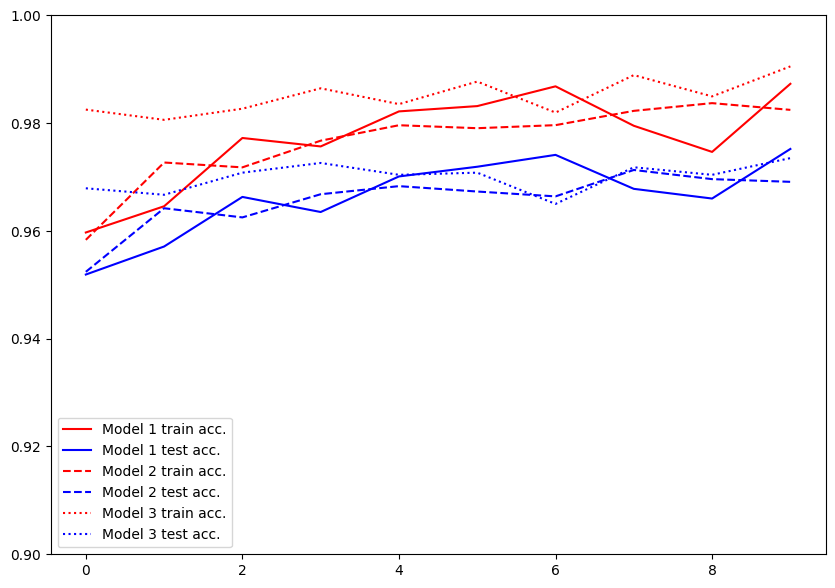

In [12]:
plt.figure(figsize = (10, 7))
plt.plot(train_accs1, "r-", label = "Model 1 train acc.")
plt.plot(test_accs1, "b-", label = "Model 1 test acc.")
plt.plot(train_accs2, "r--", label = "Model 2 train acc.")
plt.plot(test_accs2, "b--", label = "Model 2 test acc.")
plt.plot(train_accs3, "r:", label = "Model 3 train acc.")
plt.plot(test_accs3, "b:", label = "Model 3 test acc.")
plt.legend(loc = "best")
plt.ylim([0.9, 1])
plt.show()

### What's next?

In this notebook, we were able to perform image recognition using Deep Neural Networks and obtained a rather good test accuracy of 96% after training. While this appears as not too bad, this mainly has to do with MNIST being a nice dataset. In  practice, when it comes to processing images passed as inputs, the fully connected/Linear layers are not really the best choice, and they might rapidly struggle once the images become more sophisticated (higher resolution than 28x28, no longer greyscale but RGB, etc.).

In our next course, we will discuss concepts of computer vision and more specifically, the convolution operation, which is a different operation than the $ Wx + b $ one, which can be used as a layer in Neural Networks, and see why it is far superior when it comes to processing images.